# Literature-based ML Roadmap

This notebook implements a literature-based roadmap for guiding machine learning (ML) method selection in industrial product development and production.

Scientific articles are structured along three contextual dimensions:
- **Product lifecycle phase (PLC)**
- **Application domain**
- **Machine learning paradigm**

A new problem case is defined by the user through a structured problem profile. The literature is first restricted to studies matching the same contextual location. Within this subset, semantic similarity between the problem description and article titles and abstracts is computed using vector embeddings and cosine similarity.

The most similar articles are retrieved and used to provide an evidence-based overview of ML methods that have been applied to comparable problems. The roadmap is intended as decision support rather than an automated or optimal recommendation system.


In [20]:
# Imports

import pandas as pd
from pathlib import Path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from collections import Counter
import ast
from sklearn.decomposition import PCA



In [2]:
# Paths

processed_abstracts_path = Path("../../data/processed/abstracts")

# Dataset with cluster + ml-paradigm + ml-methods
cluster_path = processed_abstracts_path / "total_results" / "kmeans_scibert.csv"

# Dataset with PLC + ml-paradigm + ml-methods 
plc_path = processed_abstracts_path / "total_results" / "plc_scibert.csv"

save_path = processed_abstracts_path / "roadmap"

# Ensure directories exist
for p in [processed_abstracts_path, save_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")


All directories verified/created.


In [3]:
# Load Datasets

df_cluster = pd.read_csv(cluster_path)
df_plc = pd.read_csv(plc_path)
df_abstracts = pd.read_csv(processed_abstracts_path / "abstracts.csv")

In [4]:
# Remove abstract duplicates

# Count how many rows each query_id has
query_counts = df_abstracts["query_id"].value_counts().to_dict()

# Create a copy and map the counts to each row
df_abstracts = df_abstracts.copy()
df_abstracts["query_size"] = df_abstracts["query_id"].map(query_counts)

# Sort so that query groups with fewer rows are prioritized
df_abstracts_sorted = df_abstracts.sort_values(by="query_size", ascending=True)

# Remove duplicate DOIs, keeping the one in the smallest query group
df_abstracts_dedup = df_abstracts_sorted.drop_duplicates(subset="doi", keep="first").drop(columns=["query_size"])

# Print results
print("Original dataset size:", len(df_abstracts))
print("After removing duplicates:", len(df_abstracts_dedup))
print("Remaining duplicate DOIs:", df_abstracts_dedup["doi"].duplicated().sum())

df_abstracts = df_abstracts_dedup

Original dataset size: 52290
After removing duplicates: 33130
Remaining duplicate DOIs: 0


In [5]:
df_cluster.info()
df_cluster.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35612 entries, 0 to 35611
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     35612 non-null  int64 
 1   doi            35612 non-null  object
 2   ml_method      35612 non-null  object
 3   ml_category    35612 non-null  object
 4   prod_category  35612 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.4+ MB


,Unnamed: 0,doi,ml_method,ml_category,prod_category
0,0,10.3390/asi6050076,Linear Regression,supervised,3
1,1,10.1016/j.resconrec.2023.107073,Linear Regression,supervised,7


In [6]:
df_plc.info()
df_plc.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35689 entries, 0 to 35688
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   35689 non-null  int64 
 1   doi          35689 non-null  object
 2   ml_method    35689 non-null  object
 3   ml_category  35689 non-null  object
 4   phase        35689 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.4+ MB


,Unnamed: 0,doi,ml_method,ml_category,phase
0,0,10.3390/asi6050076,Linear Regression,supervised,1
1,1,10.1016/j.resconrec.2023.107073,Linear Regression,supervised,4


In [7]:
df_abstracts.info()
df_abstracts.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 33130 entries, 3373 to 4329
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   query_id   33130 non-null  object
 1   eid        33130 non-null  object
 2   doi        33129 non-null  object
 3   title      33130 non-null  object
 4   abstract   33130 non-null  object
 5   clean_abs  33129 non-null  object
dtypes: object(6)
memory usage: 1.8+ MB


,query_id,eid,doi,title,abstract,clean_abs
3373,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...
3374,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta..."


In [5]:
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

In [6]:
tokenizer = model.tokenizer  # tokenizer associated with MPNet model
max_len = model.get_max_seq_length()  # typically 384 for MPNet

def embed_with_chunking(text):
    tokens = tokenizer.tokenize(text)

    # If below limit -> embed normally
    if len(tokens) <= max_len:
        return model.encode(
            text,
            convert_to_numpy=True,
            normalize_embeddings=True,
        )

    # Split into chunks that fit model's input size
    chunks = [
        tokenizer.convert_tokens_to_string(tokens[i:i+max_len])
        for i in range(0, len(tokens), max_len)
    ]

    # Embed each chunk and average
    chunk_embeddings = model.encode(
        chunks,
        convert_to_numpy=True,
        normalize_embeddings=True,
    )
    return np.mean(chunk_embeddings, axis=0)




## Embedding of abstracts - no need to run this multiple times

In [ ]:
# # Batch embedding loop with chunking 

# texts = df_abstracts["clean_abs"].astype(str).tolist()
# batch_size = 512

# embeddings = []

# for start in tqdm(range(0, len(texts), batch_size), desc="Embedding abstracts"):
#     batch = texts[start:start+batch_size]

#     batch_emb = [embed_with_chunking(text) for text in batch]
#     embeddings.append(np.vstack(batch_emb))

# embeddings = np.vstack(embeddings)

# print("Embedding matrix shape:", embeddings.shape)


In [ ]:
# # Save embeddings to .npy file
# emb_path = save_path / "abstract_embeddings.npy"
# np.save(emb_path, embeddings)
# print("Saved embeddings to:", emb_path)

Saved embeddings to: ../../data/processed/abstracts/roadmap/abstract_embeddings.npy


## Embedding of Titles - no need to run this multiple times

In [24]:
# Embed titles
title_texts = df_abstracts["title"].astype(str).tolist()
batch_size = 512

title_embeddings = []
for start in tqdm(range(0, len(title_texts), batch_size), desc="Embedding titles"):
    batch = title_texts[start:start+batch_size]
    batch_emb = model.encode(
        batch,
        convert_to_numpy=True,
        normalize_embeddings=True,
    )
    title_embeddings.append(batch_emb)

title_embeddings = np.vstack(title_embeddings)
np.save(save_path / "title_embeddings.npy", title_embeddings)


Embedding titles: 100%|██████████| 65/65 [00:16<00:00,  3.94it/s]


## Build roadmap dataframe - no need to run this multiple times

In [ ]:
# # Build Roadmap DataFrame

# # Load embeddings and attach to abstracts (same row order as df_abstracts)
# abstract_embeddings = np.load(save_path / "abstract_embeddings.npy")
# df_abs = df_abstracts[["doi", "title", "clean_abs"]].copy()
# df_abs["emb_idx"] = np.arange(len(df_abs))

# # Build per-doi attributes from your labeled outputs
# plc_agg = (df_plc.groupby("doi")
#            .agg(phase=("phase", lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan),
#                 ml_category=("ml_category", lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan),
#                 ml_methods_plc=("ml_method", lambda s: sorted(set(map(str, s.dropna())))))
#            .reset_index())

# clu_agg = (df_cluster.groupby("doi")
#            .agg(prod_category=("prod_category", lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan),
#                 ml_methods_cluster=("ml_method", lambda s: sorted(set(map(str, s.dropna())))))
#            .reset_index())

# # Merge into one roadmap dataframe (one row per doi)
# df_rm = df_abs.merge(plc_agg, on="doi", how="left").merge(clu_agg, on="doi", how="left")

# def _as_list(x):
#     # Convert NaN/None to []
#     if x is None:
#         return []
#     if isinstance(x, float) and np.isnan(x):
#         return []
#     return x if isinstance(x, list) else [str(x)]

# # Use only one source for ml_methods (pick plc here)
# df_rm["ml_methods"] = df_rm["ml_methods_plc"].apply(_as_list)

# # Drop the extra columns
# df_rm = df_rm.drop(columns=["ml_methods_plc", "ml_methods_cluster"], errors="ignore")

# # Keep only abstracts that have labels in BOTH df_plc and df_cluster
# valid_dois = set(df_plc["doi"].dropna().unique()) & set(df_cluster["doi"].dropna().unique())

# df_rm = df_rm[df_rm["doi"].isin(valid_dois)].reset_index(drop=True)

# df_rm["phase"] = df_rm["phase"].astype("Int64")
# df_rm["prod_category"] = df_rm["prod_category"].astype("Int64")

# # Keep embeddings aligned with filtered df_rm
# E_abs = abstract_embeddings[df_rm["emb_idx"].to_numpy()]

# print("Filtered df_rm rows:", len(df_rm), "| unique dois:", df_rm["doi"].nunique())

# print("df_rm rows:", len(df_rm), "| unique dois:", df_rm["doi"].nunique())
# df_rm.head(2)


Filtered df_rm rows: 15205 | unique dois: 15205
df_rm rows: 15205 | unique dois: 15205


,doi,title,clean_abs,emb_idx,phase,ml_category,prod_category,ml_methods
0,10.3390/asi6050076,Measuring Carbon in Cities and Their Buildings...,"According to the European Green Deal, excessiv...",5,1,supervised,3,[Linear Regression]
1,10.1016/j.resconrec.2023.107073,Predictive modeling for the quantity of recycl...,"However, the Stacking ensemble model is less w...",6,4,supervised,7,"[Gradient Boosting, Linear Regression, Support..."


In [ ]:
# # Save Roadmap DataFrame and aligned embeddings
# rm_path = save_path / "roadmap_dataset.csv"
# df_rm.to_csv(rm_path, index=False)
# print("Saved roadmap dataset to:", rm_path)

Saved roadmap dataset to: ../../data/processed/abstracts/roadmap/roadmap_dataset.csv


In [7]:
# Load embeddings and roadmap dataframe
abstract_embeddings = np.load(save_path / "abstract_embeddings.npy")
title_embeddings = np.load(save_path / "title_embeddings.npy")

df_rm = pd.read_csv(save_path / "roadmap_dataset.csv")
E_abs = abstract_embeddings[df_rm["emb_idx"].to_numpy()]
E_title = title_embeddings[df_rm["emb_idx"].to_numpy()]

In [8]:
# Check that embeddings align with df_rm
print("Abstract embeddings shape:", E_abs.shape)
print("Title embeddings shape:", E_title.shape)


Abstract embeddings shape: (15205, 768)
Title embeddings shape: (15205, 768)


In [9]:
# Build a discrete location key
df_rm["loc_key"] = list(zip(df_rm["phase"], df_rm["prod_category"], df_rm["ml_category"].astype(str)))

# Fast lookup: loc_key -> row indices
loc_index = df_rm.groupby("loc_key").indices

print("Unique locations:", len(loc_index))


Unique locations: 151


In [10]:
# List missing (phase, cluster, category) combinations
phases = sorted(df_rm["phase"].dropna().unique().tolist())
clusters = sorted(df_rm["prod_category"].dropna().unique().tolist())
cats = sorted(df_rm["ml_category"].dropna().astype(str).unique().tolist())

observed = set(df_rm["loc_key"].tolist())
all_keys = {(p, c, k) for p in phases for c in clusters for k in cats}

missing = sorted(all_keys - observed)
print("Missing locations:", len(missing))
missing[:20]


Missing locations: 5


[(1, 1, 'unsupervised'),
 (1, 8, 'reinforcement'),
 (1, 8, 'unsupervised'),
 (1, 10, 'unsupervised'),
 (2, 10, 'unsupervised')]

In [11]:
# If df_rm is loaded from CSV, parse the ml_methods column to make it lists again, not strings

def parse_list_cell(x):
    # Convert "['a','b']" -> ['a','b']
    if isinstance(x, list):
        return x
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return []
    if isinstance(x, str):
        s = x.strip()
        if s == "" or s.lower() in ["nan", "none"]:
            return []
        try:
            v = ast.literal_eval(s)
            return v if isinstance(v, list) else [str(v)]
        except Exception:
            # Fallback: treat as single method string
            return [s]
    return [str(x)]

df_rm["ml_methods"] = df_rm["ml_methods"].apply(parse_list_cell)

In [12]:
def recommend_articles(
    query_text,
    query_phase,
    query_cluster,
    query_ml_category,
    w_title=0.25,
    topk=5,
):
    # Show full text in cells
    pd.set_option("display.max_colwidth", None)

    key = (query_phase, query_cluster, str(query_ml_category))
    idxs = loc_index.get(key, [])

    if len(idxs) == 0:
        return df_rm.iloc[0:0].copy()

    q = embed_with_chunking(str(query_text))

    idxs = np.array(list(idxs), dtype=int)

    # Similarity to title and abstract
    sim_title = E_title[idxs] @ q
    sim_abs = E_abs[idxs] @ q

    sim = w_title * sim_title + (1 - w_title) * sim_abs

    order = np.argsort(sim)[::-1][:topk]
    out = df_rm.iloc[idxs[order]].copy()
    out["sim_title"] = sim_title[order]
    out["sim_abstract"] = sim_abs[order]
    out["sim_total"] = sim[order]

    return out[
        ["doi", "title", "phase", "prod_category", "ml_category",
         "ml_methods", "sim_title", "sim_abstract", "sim_total", "emb_idx"]
    ]


In [13]:
def summarize_methods(recs, topn=8):
    # Count ml methods in recommended papers
    methods = []
    for xs in recs["ml_methods"].tolist():
        if isinstance(xs, list):
            methods.extend(xs)
    return Counter(methods).most_common(topn)


In [14]:
def get_roadmap_recommendations(
    query_text,
    query_phase,
    query_cluster,
    query_ml_category,
    topk=5,
):
    recs = recommend_articles(
        query_text=query_text,
        query_phase=query_phase,
        query_cluster=query_cluster,
        query_ml_category=query_ml_category,
        topk=topk,
    )
    methods = summarize_methods(recs) if len(recs) > 0 else []
    return recs, methods


## Example queries to check Roadmap output

In [42]:
query_text = "Predictive maintenance for rotating equipment using sensor data and fault prediction"

recs, top_methods = get_roadmap_recommendations(
    query_text=query_text,
    query_phase=3,            # Optimization
    query_cluster=8,          # Predictive maintenance
    query_ml_category="supervised",
    topk=5,
)

display(recs.reset_index(drop=True))
print("Recommended ML methods:", top_methods)

,doi,title,phase,prod_category,ml_category,ml_methods,sim_title,sim_abstract,sim_total,emb_idx
0,10.3390/app15137580,Supervised Learning-Based Fault Classification in Industrial Rotating Equipment Using Multi-Sensor Data,3,8,supervised,"[K-Nearest Neighbors, Random Forest, Support Vector Machine]",0.803741,0.695158,0.722304,17643
1,10.1007/s10845-016-1244-8,Prognostics of multiple failure modes in rotating machinery using a pattern-based classifier and cumulative incidence functions,3,8,supervised,"[Neural Network, Support Vector Regression]",0.724777,0.717392,0.719238,9071
2,10.1016/j.compeleceng.2025.110604,"Elevating rotating machinery fault analysis: A multifaceted strategy with FFT, PCA, ANN, and K-means",3,8,supervised,[Principal Component Analysis],0.664665,0.732655,0.715657,20540
3,10.1063/5.0183426,Vibration Analysis and Predictive Maintenance on Gearbox of Lathe Machine Using Machine Learning,3,8,supervised,[Linear Regression],0.626050,0.741213,0.712422,9759
4,10.5957/SOME-2023-025,Fault Classification and Diagnosis for Rotating Equipment using Machine Learning Algorithms,3,8,supervised,"[K-Nearest Neighbors, Support Vector Machine]",0.745417,0.691319,0.704844,19517


Recommended ML methods: [('K-Nearest Neighbors', 2), ('Support Vector Machine', 2), ('Random Forest', 1), ('Neural Network', 1), ('Support Vector Regression', 1), ('Principal Component Analysis', 1), ('Linear Regression', 1)]


### Visualize one example query using PCA

In [61]:
# Location from the query 
loc_key = (3, 8, "supervised")

# Indices (row positions) in df_rm for same location
loc_rowpos = np.array(list(loc_index.get(loc_key, [])), dtype=int)

# Recommended article emb_idx (global)
rec_emb_idx = recs["emb_idx"].to_numpy()

# Convert df_rm rowpos -> global emb_idx for same location
loc_emb_idx = df_rm.iloc[loc_rowpos]["emb_idx"].to_numpy()

# Background = same location but not recommended
bg_emb_idx = np.setdiff1d(loc_emb_idx, rec_emb_idx)

# Sample background (adjust n as needed)
n_bg = min(40, len(bg_emb_idx))
bg_sample = np.random.choice(bg_emb_idx, size=n_bg, replace=False) if n_bg > 0 else np.array([], dtype=int)

print("Same-location articles:", len(loc_emb_idx), "| background sample:", len(bg_sample), "| recommended:", len(rec_emb_idx))


Same-location articles: 1140 | background sample: 40 | recommended: 5


In [62]:
def plot_query_vs_location_pca(query_emb, emb_matrix, rec_idx, bg_idx, title):
    # Build matrix: [query, recommended..., background...]
    if len(bg_idx) > 0:
        X = np.vstack([query_emb, emb_matrix[rec_idx], emb_matrix[bg_idx]])
    else:
        X = np.vstack([query_emb, emb_matrix[rec_idx]])

    X2 = PCA(n_components=2).fit_transform(X)

    n_rec = len(rec_idx)
    q_xy = X2[0]
    rec_xy = X2[1:1 + n_rec]
    bg_xy = X2[1 + n_rec:] if len(bg_idx) > 0 else None

    plt.figure(figsize=(6, 5))

    if bg_xy is not None and len(bg_xy) > 0:
        plt.scatter(
            bg_xy[:, 0],
            bg_xy[:, 1],
            alpha=0.25,
            label="Same-location articles (not recommended)",
        )

    plt.scatter(
        rec_xy[:, 0],
        rec_xy[:, 1],
        s=80,
        label="Recommended articles",
    )

    plt.scatter(
        q_xy[0],
        q_xy[1],
        s=140,
        marker="*",
        label="Query",
    )

    plt.xlabel("PCA component 1")
    plt.ylabel("PCA component 2")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


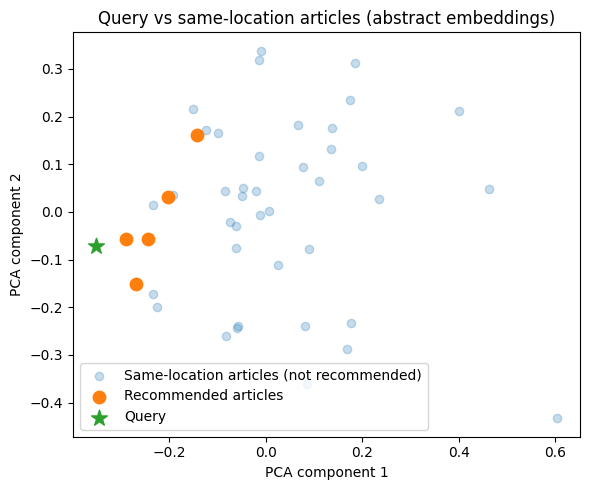

In [63]:
query_abs = embed_with_chunking(query_text)

plot_query_vs_location_pca(
    query_emb=query_abs,
    emb_matrix=abstract_embeddings,     # global matrix
    rec_idx=rec_emb_idx,                # global emb_idx
    bg_idx=bg_sample,                   # global emb_idx
    title="Query vs same-location articles (abstract embeddings)",
)


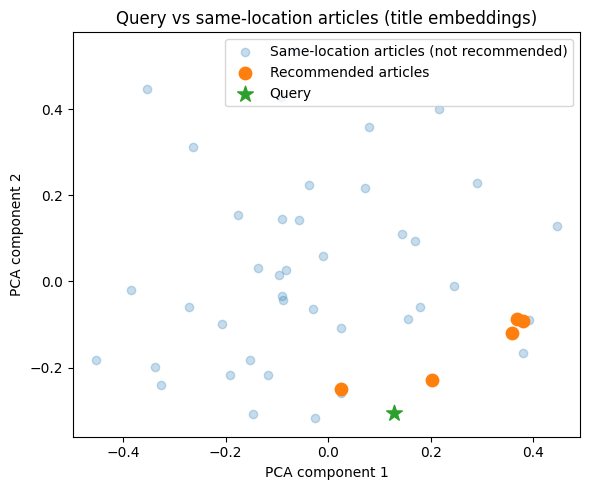

In [64]:
query_title = model.encode([query_text], convert_to_numpy=True, normalize_embeddings=True)[0]

plot_query_vs_location_pca(
    query_emb=query_title,
    emb_matrix=title_embeddings,        # global matrix
    rec_idx=rec_emb_idx,                # global emb_idx
    bg_idx=bg_sample,                   # global emb_idx
    title="Query vs same-location articles (title embeddings)",
)


In [29]:
query_text = "Predictive maintenance for car engine"

recs, top_methods = get_roadmap_recommendations(
    query_text=query_text,
    query_phase=3,
    query_cluster=8,
    query_ml_category="supervised",
    topk=5,
)

display(recs.reset_index(drop=True))
print("Recommended ML methods:", top_methods)


,doi,title,phase,prod_category,ml_category,ml_methods,sim_title,sim_abstract,sim_total,emb_idx
0,10.1016/j.engappai.2025.111199,"Optimizing aircraft engine longevity: A comparative framework for dynamically adaptive predictive maintenance using autoencoders, LSTMs, and Gaussian processes",3,8,supervised,[Gaussian Process Regression],0.682577,0.753321,0.735635,8981
1,10.1063/5.0173800,Short Term Predictive Maintenance Using Machine Learning Models,3,8,supervised,"[Decision Tree, Linear Regression]",0.738961,0.676061,0.691786,19216
2,10.1109/DeSE.2019.00181,A jet engine prognostic and diagnostic system based on bayesian classifier,3,8,supervised,[Bayesian Method],0.626479,0.713551,0.691783,20238
3,10.1007/978-981-16-2183-3_65,Predictive Maintenance for a Turbofan Engine Using Data Mining,3,8,supervised,[Support Vector Machine],0.775021,0.663278,0.691214,19756
4,10.1007/978-3-031-65522-7_9,Prediction of Automotive Vehicles Engine Health Using MLP and LR,3,8,supervised,"[Logistic Regression, Multi-Layer Perceptron]",0.670471,0.688690,0.684135,18925


Recommended ML methods: [('Gaussian Process Regression', 1), ('Decision Tree', 1), ('Linear Regression', 1), ('Bayesian Method', 1), ('Support Vector Machine', 1), ('Logistic Regression', 1), ('Multi-Layer Perceptron', 1)]


In [95]:
query_text = "Automated defect detection in manufacturing using image-based machine learning"

recs, top_methods = get_roadmap_recommendations(
    query_text=query_text,
    query_phase=3,            # Optimization
    query_cluster=9,          # Defect / quality
    query_ml_category="supervised",
    topk=5,
)

display(recs.reset_index(drop=True))
print("Recommended ML methods:", top_methods)


,doi,title,phase,prod_category,ml_category,ml_methods,sim_title,sim_abstract,sim_total
0,10.1088/2051-672X/ac9247,Smart defect identification for manufacturing applications,3,9,supervised,[Neural Network],0.739728,0.775194,0.766327
1,10.1109/AEECA52519.2021.9574344,Detection and Classification of Metal Workpiece Surface Defects Based on Machine Vision,3,9,supervised,"[K-Nearest Neighbors, Support Vector Machine]",0.720465,0.756501,0.747492
2,10.29284/ijasis.7.2.2021.40-48,AN EFFICIENT QUALITY CONTROL SYSTEM BY MACHINE LEARNING FOR SURFACE DEFECTS,3,9,supervised,[Principal Component Analysis],0.737791,0.700542,0.709854
3,10.1109/ISAS66241.2025.11101807,Defect Detection in Manufacturing: A Comparative Study of Machine Learning and Fuzzy Rule-Based Systems,3,9,supervised,"[Decision Tree, Gradient Boosting, K-Nearest Neighbors, Logistic Regression, Random Forest, SHAP, Support Vector Machine]",0.813642,0.666040,0.702940
4,10.4028/www.scientific.net/AMM.541-542.1447,Study on the Parts Surface Defect Detection Method Based on Modifed SVM Algorithm,3,9,supervised,"[Particle Swarm Optimization, Support Vector Machine]",0.633322,0.699838,0.683209


Recommended ML methods: [('Support Vector Machine', 3), ('K-Nearest Neighbors', 2), ('Neural Network', 1), ('Principal Component Analysis', 1), ('Decision Tree', 1), ('Gradient Boosting', 1), ('Logistic Regression', 1), ('Random Forest', 1)]


In [96]:
query_text = "Energy consumption forecasting for industrial facilities using historical sensor data"

recs, top_methods = get_roadmap_recommendations(
    query_text=query_text,
    query_phase=4,            # Use and Reuse
    query_cluster=3,          # Energy
    query_ml_category="supervised",
    topk=5,
)

display(recs.reset_index(drop=True))
print("Recommended ML methods:", top_methods)


,doi,title,phase,prod_category,ml_category,ml_methods,sim_title,sim_abstract,sim_total
0,10.1007/978-3-319-59153-7_57,Hybrid model for large scale forecasting of power consumption,4,3,supervised,"[Linear Regression, Random Forest]",0.676848,0.621451,0.635301
1,10.1109/JSEN.2024.3403484,SmartLVEnergy: An AIoT Framework for Energy Management Through Distributed Processing and Sensor-Actuator Integration in Legacy Low-Voltage Systems,4,3,supervised,[LSTM],0.473735,0.682131,0.630032
2,10.1109/ICCoSITE57641.2023.10127735,Multivariate time series with Prophet Facebook and LSTM algorithm to predict the energy consumption,4,3,supervised,"[LSTM, Prophet]",0.567771,0.627975,0.612924
3,10.1016/j.eswa.2025.128366,High-precision short-term industrial energy consumption forecasting via parallel-NN with Adaptive Universal Decomposition,4,3,supervised,[Neural Network],0.599686,0.593213,0.594831
4,10.1016/j.egyai.2025.100504,Industrial energy forecasting using dynamic attention neural networks,4,3,supervised,[Recurrent Neural Network],0.565081,0.604114,0.594356


Recommended ML methods: [('LSTM', 2), ('Linear Regression', 1), ('Random Forest', 1), ('Prophet', 1), ('Neural Network', 1), ('Recurrent Neural Network', 1)]


In [97]:
query_text = "Reinforcement learning for real-time production scheduling and process control"

recs, top_methods = get_roadmap_recommendations(
    query_text=query_text,
    query_phase=3,            # Optimization
    query_cluster=0,          # Control / RL
    query_ml_category="reinforcement",
    topk=5,
)

display(recs.reset_index(drop=True))
print("Recommended ML methods:", top_methods)


,doi,title,phase,prod_category,ml_category,ml_methods,sim_title,sim_abstract,sim_total
0,10.1007/s12555-019-0120-7,Model-free Adaptive Optimal Control of Episodic Fixed-horizon Manufacturing Processes Using Reinforcement Learning,3,0,reinforcement,[Q-Learning],0.733425,0.683077,0.695664
1,10.1002/qre.3714,Joint Optimization of Condition-Based Maintenance and Production Rate Using Reinforcement Learning Algorithms,3,0,reinforcement,[Q-Learning],0.632083,0.673000,0.662771
2,10.1016/j.compchemeng.2023.108232,A practical Reinforcement Learning implementation approach for continuous process control,3,0,reinforcement,"[Deep Deterministic Policy Gradient, Policy Gradient]",0.759552,0.627383,0.660425
3,10.1109/CCTA.2019.8920472,Optimization control of a fed-batch process using an improved reinforcement learning algorithm,3,0,reinforcement,"[Neural Network, Q-Learning]",0.682028,0.647377,0.656040
4,10.1002/amp2.10113,Benchmark study of reinforcement learning in controlling and optimizing batch processes,3,0,reinforcement,[Actor-Critic],0.700595,0.641137,0.656002


Recommended ML methods: [('Q-Learning', 3), ('Deep Deterministic Policy Gradient', 1), ('Policy Gradient', 1), ('Neural Network', 1), ('Actor-Critic', 1)]


In [98]:
query_text = "Machine learning for demand forecasting and supply chain planning in product development"

recs, top_methods = get_roadmap_recommendations(
    query_text=query_text,
    query_phase=1,            # Planning
    query_cluster=7,          # Product / supply chain
    query_ml_category="supervised",
    topk=5,
)

display(recs.reset_index(drop=True))
print("Recommended ML methods:", top_methods)


,doi,title,phase,prod_category,ml_category,ml_methods,sim_title,sim_abstract,sim_total
0,10.1109/ICIPTM54933.2022.9753864,Application of different Machine Learning models for Supply Chain Demand Forecasting: Comparative Analysis,1,7,supervised,"[Convolutional Neural Network, LSTM, Multi-Layer Perceptron, Neural Network]",0.728779,0.731615,0.730906
1,10.1016/j.ijpe.2025.109688,Machine learning applied to forecasting the manufacturing time of new products prototypes and ETO products: An exploratory study,1,7,supervised,"[Neural Network, Random Forest, Support Vector Machine]",0.715203,0.708166,0.709926
2,10.1109/ICMLA.2019.00029,An industry case of large-scale demand forecasting of hierarchical components,1,7,supervised,[ARIMA],0.633819,0.721483,0.699567
3,10.1109/SLAAI-ICAI63667.2024.10844978,Advancing Demand Forecasting for Material Requirements Planning in Food Manufacturing: A Hierarchical Forecasting Approach,1,7,supervised,"[ARIMA, Gradient Boosting, K-Nearest Neighbors, Linear Regression, Prophet, Random Forest, Support Vector Regression, XGBoost]",0.670089,0.701647,0.693758
4,10.1007/978-3-030-73280-6_15,Demand Forecasting for Textile Products Using Statistical Analysis and Machine Learning Algorithms,1,7,supervised,[Neural Network],0.707658,0.677901,0.685340


Recommended ML methods: [('Neural Network', 3), ('Random Forest', 2), ('ARIMA', 2), ('Convolutional Neural Network', 1), ('LSTM', 1), ('Multi-Layer Perceptron', 1), ('Support Vector Machine', 1), ('Gradient Boosting', 1)]


In [116]:
query_text = "Optimization of laser parameters in additive manufacturing using machine learning"

recs, top_methods = get_roadmap_recommendations(
    query_text=query_text,
    query_phase=2,            # Development & Production
    query_cluster=5,          # Additive manufacturing
    query_ml_category="supervised",
    topk=5,
)

display(recs.reset_index(drop=True))
print("Recommended ML methods:", top_methods)


,doi,title,phase,prod_category,ml_category,ml_methods,sim_title,sim_abstract,sim_total
0,10.3390/app112411949,Bead geometry prediction in laser-wire additive manufacturing process using machine learning: Case of study,2,5,supervised,[Neural Network],0.815194,0.779838,0.788677
1,10.1117/12.3071509,Research progress on additive manufacturing process parameter optimization based on machine learning,2,5,supervised,"[Neural Network, Random Forest, Support Vector Machine]",0.832513,0.763724,0.780921
2,10.1177/09544062241288948,Optimal process parameter determination in selective laser melting via machine learning-guided sequential quadratic programing,2,5,supervised,"[Gaussian Process Regression, Neural Network, Support Vector Machine]",0.738472,0.792744,0.779176
3,10.1088/1402-4896/aca3da,Machine learning-driven process of alumina ceramics laser machining,2,5,supervised,[Neural Network],0.751383,0.779384,0.772384
4,10.3390/app12052324,A Comparative Study of Machine Learning Methods for Computational Modeling of the Selective Laser Melting Additive Manufacturing Process,2,5,supervised,"[Deep Neural Network, Differential Evolution, Genetic Algorithm, Neural Network, Particle Swarm Optimization]",0.823393,0.746486,0.765713


Recommended ML methods: [('Neural Network', 5), ('Support Vector Machine', 2), ('Random Forest', 1), ('Gaussian Process Regression', 1), ('Deep Neural Network', 1), ('Differential Evolution', 1), ('Genetic Algorithm', 1), ('Particle Swarm Optimization', 1)]


In [100]:
query_text = "Remaining useful life prediction for lithium-ion batteries using machine learning"

recs, top_methods = get_roadmap_recommendations(
    query_text=query_text,
    query_phase=4,            # Use and Reuse
    query_cluster=10,         # Battery / RUL
    query_ml_category="supervised",
    topk=5,
)

display(recs.reset_index(drop=True))
print("Recommended ML methods:", top_methods)


,doi,title,phase,prod_category,ml_category,ml_methods,sim_title,sim_abstract,sim_total
0,10.3390/electronics10243126,Overview of machine learning methods for lithium-ion battery remaining useful lifetime prediction,4,10,supervised,[Deep Neural Network],0.934077,0.871588,0.887210
1,10.19799/j.cnki.2095-4239.2024.0098,Review of the remaining useful life prediction methods for lithium-ion batteries,4,10,supervised,"[Gaussian Process Regression, Neural Network, Support Vector Machine, Transformers]",0.893563,0.879860,0.883285
2,10.1109/GECOST55694.2022.10010569,Review on Machine Learning Methods for Remaining Useful Lifetime Prediction of Lithium-ion Batteries,4,10,supervised,"[LSTM, Neural Network, Support Vector Machine]",0.960006,0.845233,0.873926
3,10.1109/ICCSAI59793.2023.10421014,Machine Learning based Remaining Useful Life Prediction of Lithium-ion Batteries in Electric Vehicle Battery Management System,4,10,supervised,[Random Forest],0.908472,0.855192,0.868512
4,10.3390/a18060303,Forecasting the Remaining Useful Life of Lithium-Ion Batteries Using Machine Learning Models—A Web-Based Application,4,10,supervised,"[Extra Trees, LSTM, Linear Regression, Neural Network, Random Forest]",0.908400,0.822800,0.844200


Recommended ML methods: [('Neural Network', 3), ('Support Vector Machine', 2), ('LSTM', 2), ('Random Forest', 2), ('Deep Neural Network', 1), ('Gaussian Process Regression', 1), ('Transformers', 1), ('Extra Trees', 1)]


In [101]:
query_text = "Machine learning for optimization of chemical reaction processes in industrial production"

recs, top_methods = get_roadmap_recommendations(
    query_text=query_text,
    query_phase=2,            # or 3 depending on framing
    query_cluster=12,         # Chemical / energy
    query_ml_category="supervised",
    topk=5,
)

display(recs.reset_index(drop=True))
print("Recommended ML methods:", top_methods)


,doi,title,phase,prod_category,ml_category,ml_methods,sim_title,sim_abstract,sim_total
0,10.1016/j.compchemeng.2025.109470,Sustainable optimization of CHOSYN networks in eco-industrial systems via a hybrid machine learning and mathematical programming approach,2,12,supervised,[Neural Network],0.543320,0.728468,0.682181
1,10.1201/9781003186823-9,Revolutionizing chemical engineering 4.0: Artificial intelligence innovations and machine learning,2,12,supervised,[Neural Network],0.686131,0.630984,0.644771
2,10.1021/acs.iecr.4c01003,"Continuous Flow Synthesis of N,O-Dimethyl-N′-nitroisourea Monitored by Inline Fourier Transform Infrared Spectroscopy: Bayesian Optimization and Kinetic Modeling",2,12,supervised,[Bayesian Method],0.339893,0.695799,0.606822
3,10.1021/acsomega.3c02344,Robust Design of a Dimethyl Ether Production Process Using Process Simulation and Robust Bayesian Optimization,2,12,supervised,[Bayesian Method],0.523608,0.615851,0.592790
4,10.1039/d4se01045k,"Advances in plastic to fuel conversion: reactor design, operational optimization, and machine learning integration",2,12,supervised,"[Neural Network, Support Vector Regression]",0.511649,0.618648,0.591898


Recommended ML methods: [('Neural Network', 3), ('Bayesian Method', 2), ('Support Vector Regression', 1)]


In [105]:
query_text = "Anomaly detection for manufacturing quality monitoring using sensor data"

recs, top_methods = get_roadmap_recommendations(
    query_text=query_text,
    query_phase=3,
    query_cluster=9,
    query_ml_category="unsupervised",
    topk=5,
)

display(recs.reset_index(drop=True))
print("Recommended ML methods:", top_methods)


,doi,title,phase,prod_category,ml_category,ml_methods,sim_title,sim_abstract,sim_total
0,10.1109/ICDSCNC62492.2024.10939633,Anomaly Detection in Industrial Quality Control with Computer Vision and Deep Learning,3,9,unsupervised,"[Convolutional Neural Network, Neural Network]",0.741469,0.638980,0.664602
1,10.1115/1.4068472,3D-ADCS: Untrained 3D Anomaly Detection for Complex Manufacturing Surfaces,3,9,unsupervised,[Principal Component Analysis],0.615061,0.617999,0.617265
2,10.1016/j.ifacol.2021.08.144,Fingerprint analysis for machine tool health condition monitoring,3,9,unsupervised,[Principal Component Analysis],0.554753,0.630553,0.611603
3,10.1109/ICIS64839.2024.10887500,Optimization of Post-Production Quality Control of Steel Products Using Autoencoder Algorithm for AI-Based Anomaly Detection,3,9,unsupervised,[Autoencoder],0.667726,0.590003,0.609434
4,10.3390/make6010001,Autoencoder-Based Visual Anomaly Localization for Manufacturing Quality Control,3,9,unsupervised,"[Autoencoder, K-Means]",0.687128,0.563868,0.594683


Recommended ML methods: [('Principal Component Analysis', 2), ('Autoencoder', 2), ('Convolutional Neural Network', 1), ('Neural Network', 1), ('K-Means', 1)]


In [107]:
query_text = "Discovery of operational patterns in industrial process data"

recs, top_methods = get_roadmap_recommendations(
    query_text=query_text,
    query_phase=3,
    query_cluster=0,
    query_ml_category="unsupervised",
    topk=5,
)

display(recs.reset_index(drop=True))
print("Recommended ML methods:", top_methods)


,doi,title,phase,prod_category,ml_category,ml_methods,sim_title,sim_abstract,sim_total
0,10.3390/min13111360,Machine Learning Algorithms for Semi-Autogenous Grinding Mill Operational Regions’ Identification,3,0,unsupervised,[K-Means],0.492071,0.546044,0.532551
1,10.1002/ansa.202000122,Estimation and visualization of process states using latent variable models based on Gaussian process,3,0,unsupervised,[Bayesian Method],0.489441,0.498257,0.496053
2,10.1016/B978-0-323-95879-0.50017-5,Probabilistic machine learning based soft-sensors for product quality prediction in batch processes,3,0,unsupervised,[Partial Least Squares],0.354088,0.500308,0.463753
3,10.1016/j.cej.2025.167895,Integrating physical modeling and machine learning for reaction activity dynamic prediction in chemical reactors,3,0,unsupervised,[LSTM],0.423392,0.435797,0.432696
4,10.1109/JIOT.2025.3613830,Broad Learning System Combined with Feature Weighted Stacked Target-Related Laplacian Autoencoder for Industrial Quality Prediction,3,0,unsupervised,[Autoencoder],0.338162,0.419984,0.399528


Recommended ML methods: [('K-Means', 1), ('Bayesian Method', 1), ('Partial Least Squares', 1), ('LSTM', 1), ('Autoencoder', 1)]


In [108]:
query_text = "Analysis and grouping of industrial energy consumption profiles"

recs, top_methods = get_roadmap_recommendations(
    query_text=query_text,
    query_phase=4,
    query_cluster=3,
    query_ml_category="unsupervised",
    topk=5,
)

display(recs.reset_index(drop=True))
print("Recommended ML methods:", top_methods)


,doi,title,phase,prod_category,ml_category,ml_methods,sim_title,sim_abstract,sim_total
0,10.3390/su14074033,Heat Load Profiles in Industry and the Tertiary Sector: Correlation with Electricity Consumption and Ex Post Modeling,4,3,unsupervised,[LSTM],0.657208,0.471425,0.517871
1,10.1016/B978-0-443-28824-1.50369-0,Surrogate Based Mixed Integer Linear Programming Model for Decarbonization of an Integrated Gas-Oil Separation Network,4,3,unsupervised,[Neural Network],0.344964,0.468599,0.437690
2,10.1177/23998083241312948,Using a machine learning framework for natural language processing to create a high-resolution carbon emission map for urban manufacturing,4,3,unsupervised,[Transformers],0.380747,0.432676,0.419694
3,10.1109/ECCE55643.2024.10861733,Optimizing PV Array Performance: A2 LSTM for Anomaly Detection and Predictive Maintenance based on Machine Learning,4,3,unsupervised,"[Attention Mechanism, K-Means, LSTM]",0.212577,0.301561,0.279315
4,10.1201/9781003564874-5,"Deep convolution models: Basic definitions, types, and applications in solar energy, engineering, and finance",4,3,unsupervised,"[Neural Network, Transformers]",0.217589,0.211577,0.213080


Recommended ML methods: [('LSTM', 2), ('Neural Network', 2), ('Transformers', 2), ('Attention Mechanism', 1), ('K-Means', 1)]


In [110]:
query_text = "Identification of equipment health states from condition monitoring data"

recs, top_methods = get_roadmap_recommendations(
    query_text=query_text,
    query_phase=4,
    query_cluster=8,
    query_ml_category="unsupervised",
    topk=5,
)

display(recs.reset_index(drop=True))
print("Recommended ML methods:", top_methods)


,doi,title,phase,prod_category,ml_category,ml_methods,sim_title,sim_abstract,sim_total
0,10.1109/ACCAI61061.2024.10601981,Predictive Maintenance of Electrical Machines using Machine Learning and Condition Monitoring Data,4,8,unsupervised,"[Neural Network, Principal Component Analysis, Random Forest]",0.660652,0.665532,0.664312
1,10.1109/ICAC2N63387.2024.10895271,Machine Learning in Predictive Maintenance for Industrial Equipment,4,8,unsupervised,"[Decision Tree, Neural Network]",0.668898,0.647183,0.652612
2,10.1117/12.2618913,PROGNOS: An Automatic Remaining Useful Life (RUL) Prediction Model for Military Systems Using Machine Learning,4,8,unsupervised,"[Kalman Filter, LSTM, Principal Component Analysis]",0.517133,0.680263,0.639481
3,10.1109/TQCEBT59414.2024.10545280,Machine Learning-Based Predictive Maintenance for Industrial Equipment Optimization,4,8,unsupervised,[Explainable AI],0.617604,0.638555,0.633317
4,10.24868/11149,Enhancing Predictive Maintenance in the Maritime Industry with Unsupervised Learning,4,8,unsupervised,"[LSTM, Neural Network]",0.488741,0.677937,0.630638


Recommended ML methods: [('Neural Network', 3), ('Principal Component Analysis', 2), ('LSTM', 2), ('Random Forest', 1), ('Decision Tree', 1), ('Kalman Filter', 1), ('Explainable AI', 1)]


In [112]:
query_text = "Grouping of material properties to support manufacturing process understanding"

recs, top_methods = get_roadmap_recommendations(
    query_text=query_text,
    query_phase=2,
    query_cluster=11,
    query_ml_category="unsupervised",
    topk=5,
)

display(recs.reset_index(drop=True))
print("Recommended ML methods:", top_methods)


,doi,title,phase,prod_category,ml_category,ml_methods,sim_title,sim_abstract,sim_total
0,10.1109/ICE/ITMC65658.2025.11106594,DiMAT Materials Modeler (DiMM): An Interactive Framework for Materials Property Prediction and Optimization Using a Hybrid Machine Learning - Genetic Algorithm Approach,2,11,unsupervised,[Genetic Algorithm],0.521846,0.568059,0.556506
1,10.3390/polym14091855,A Novel High Recognition Rate Defect Inspection Method for Carbon Fiber Plain-Woven Prepreg Based on Image Texture Feature Compression,2,11,unsupervised,[K-Means],0.296150,0.346118,0.333626
2,10.1002/admt.202401566,Continuous Flow Synthesis of Prussian Blue and Analogues Assisted by AI,2,11,unsupervised,[Bayesian Method],0.228643,0.335865,0.309059
3,10.3390/prosthesis3040027,Characterising Residual Limb Morphology and Prosthetic Socket Design Based on Expert Clinician Practice,2,11,unsupervised,"[K-Means, Principal Component Analysis]",0.128793,0.354994,0.298443
4,10.1016/j.ifacol.2022.07.513,Machine learning-based analysis of the physio-chemical properties for the predictive thickness control of atomic layer deposition,2,11,unsupervised,[Principal Component Analysis],0.381127,0.261433,0.291356


Recommended ML methods: [('K-Means', 2), ('Principal Component Analysis', 2), ('Genetic Algorithm', 1), ('Bayesian Method', 1)]


In [113]:
query_text = "Data-driven decision policies for industrial maintenance planning"

recs, top_methods = get_roadmap_recommendations(
    query_text=query_text,
    query_phase=4,
    query_cluster=8,
    query_ml_category="reinforcement",
    topk=5,
)

display(recs.reset_index(drop=True))
print("Recommended ML methods:", top_methods)


,doi,title,phase,prod_category,ml_category,ml_methods,sim_title,sim_abstract,sim_total
0,10.18280/jesa.580401,Artificial Intelligence Techniques for Industrial Predictive Maintenance: A Systematic Review of Recent Advances,4,8,reinforcement,"[Deep Reinforcement Learning, Explainable AI]",0.681402,0.679952,0.680314
1,10.1109/TR.2024.3459649,Selective Maintenance Optimization Under Limited Maintenance Capacities: A Machine Learning-Enhanced Approximate Dynamic Programming,4,8,reinforcement,[Neural Network],0.624648,0.677294,0.664133
2,10.1016/j.sca.2024.100078,An explainable artificial intelligence model for predictive maintenance and spare parts optimization,4,8,reinforcement,[Explainable AI],0.619162,0.675457,0.661383
3,10.3390/app15158507,Prescriptive Maintenance: A Systematic Literature Review and Exploratory Meta-Synthesis,4,8,reinforcement,[Deep Reinforcement Learning],0.355370,0.702274,0.615548
4,10.1109/ASIANCON62057.2024.10837862,Machine Learning for Predictive Maintenance in Industrial Equipment: Challenges and Application,4,8,reinforcement,[Explainable AI],0.633051,0.608142,0.614369


Recommended ML methods: [('Explainable AI', 3), ('Deep Reinforcement Learning', 2), ('Neural Network', 1)]


In [114]:
query_text = "Adaptive real-time control of industrial processes based on operational data"

recs, top_methods = get_roadmap_recommendations(
    query_text=query_text,
    query_phase=3,
    query_cluster=0,
    query_ml_category="reinforcement",
    topk=5,
)

display(recs.reset_index(drop=True))
print("Recommended ML methods:", top_methods)


,doi,title,phase,prod_category,ml_category,ml_methods,sim_title,sim_abstract,sim_total
0,10.1016/j.ifacol.2022.07.573,Adaptive Contraction-based Control of Uncertain Nonlinear Processes using Neural Networks,3,0,reinforcement,[Neural Network],0.554469,0.578715,0.572653
1,10.1109/SSCI.2018.8628664,Adaptive Critic Design for Extreme Learning Machines applied to noisy and drifting industrial processes,3,0,reinforcement,[Neural Network],0.525047,0.578020,0.564776
2,10.1007/978-981-96-1777-7_46,Reinforcement Learning Based Data-Driven Control Method for Dynamic Systems and Its Application to FLUIDMechatronix Platform,3,0,reinforcement,"[Actor-Critic, Neural Network]",0.492320,0.582725,0.560124
3,10.1007/s43153-023-00351-w,A comparison between process control strategies: reinforcement learning with RBFs and NMPC coupled with EKF,3,0,reinforcement,"[Actor-Critic, Kalman Filter, Neural Network]",0.563548,0.546867,0.551037
4,10.1016/j.compchemeng.2023.108232,A practical Reinforcement Learning implementation approach for continuous process control,3,0,reinforcement,"[Deep Deterministic Policy Gradient, Policy Gradient]",0.600345,0.527582,0.545773


Recommended ML methods: [('Neural Network', 4), ('Actor-Critic', 2), ('Kalman Filter', 1), ('Deep Deterministic Policy Gradient', 1), ('Policy Gradient', 1)]
